In [ ]:
!pip install sktime
!pip install neuralforecast
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn import preprocessing, svm
from statsmodels.tsa.stattools import adfuller
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import OptimizedTheta, SeasonalNaive, HoltWinters
import datetime

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST, TimesNet
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, rmse

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import re
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (9,6)

### Functions

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, period: int, method: str) -> list:

    seasonal_steps = int((window/period))

    TOTAL_LEN = train_len + horizon

    if method == 'last_season':
        pred_last_season = []

        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)

        return pred_last_season[0][:horizon]

    elif method == 'theta':
        pred_theta = []

        for i in range(train_len, TOTAL_LEN, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)


        return pred_theta

    elif method == 'tes':
        pred_tes = []

        for i in range(train_len, TOTAL_LEN, window):
            tes = ExponentialSmoothing(
                df[:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()

            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

        return pred_tes

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(2,1,3), seasonal_order=(1,0,2,52))
            res = model.fit(cov_type='none')
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [ ]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):

    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)

    all_orders = list(product(all_p, all_q, all_P, all_Q))

    print(f'Fitting {len(all_orders)} unique models')

    results = []

    for order in tqdm_notebook(all_orders):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False)
        except:
            continue

        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
def ljung_box_test(residuals, is_seasonal, period):

    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])

        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()

    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
#######################
### Model framework ###
#######################

def cap_floor(train_dset, test_dset, name, growth = 'linear'):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    ### Baseline model ###

    m = Prophet()
    m.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_hrs = Prophet(weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True,
                    seasonality_mode = 'additive',
                    changepoint_prior_scale = 0.01,
                    seasonality_prior_scale = 0.01,
                    holidays=holidays,
                    growth = growth)

    m_hrs.add_regressor('Is_month_end')
    m_hrs.add_regressor('Year')
    m_hrs.add_regressor('Month')
    m_hrs.add_regressor('Day')
    m_hrs.add_regressor('Week')
    m_hrs.add_regressor('Dayofyear')
    #m_hrs.add_regressor('Dayofweek')
    m_hrs.add_regressor('Is_month_start')
    m_hrs.add_regressor('Is_quarter_end')
    m_hrs.add_regressor('Is_quarter_start')
    #m_hrs.add_regressor('Is_year_end')
    #m_hrs.add_regressor('Is_year_start')
    m_hrs.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_comp = Prophet(growth = growth,
                    seasonality_mode = 'additive',      # seasonality_mode = 'multiplicative',
                    changepoint_prior_scale = 0.01,
                    seasonality_prior_scale = 0.01,
                    holidays_prior_scale = 0.01,
                    weekly_seasonality = True,
                    daily_seasonality = True,
                    yearly_seasonality = False,
                    holidays=holidays,
                    ).add_seasonality(
                        name = 'daily',
                        period = 1,
                        fourier_order = 3,
                        prior_scale = 30
                    ).add_seasonality(
                        name = 'weekly',
                        period = 7,
                        fourier_order = 10,
                        prior_scale = 40
                    )

    m_comp.add_regressor('Is_month_end')
    m_comp.add_regressor('Year')
    m_comp.add_regressor('Month')
    m_comp.add_regressor('Day')
    m_comp.add_regressor('Week')
    #m_comp.add_regressor('Dayofweek')
    m_comp.add_regressor('Dayofyear')
    #m_comp.add_regressor('Hour')
    m_comp.add_regressor('Is_month_start')
    m_comp.add_regressor('Is_quarter_end')
    m_comp.add_regressor('Is_quarter_start')
    #m_comp.add_regressor('Is_year_end')
    #m_comp.add_regressor('Is_year_start')
    m_comp.fit(train_dset)

    df_all = pd.DataFrame()

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    prop_test = mod_diag(m, 'Baseline model', test_dset, y_train, y_test, name)
    prop_test['Model'] = 'Baseline'
    df_all = pd.concat([df_all,prop_test], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    prop_test = mod_diag(m_hrs, 'Holiday-Regressor-Seasonal model', test_dset, y_train, y_test, name)
    prop_test['Model'] = 'HRS'
    df_all = pd.concat([df_all,prop_test], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    prop_test = mod_diag(m_comp, 'Constructed model', test_dset, y_train, y_test, name)
    prop_test['Model'] = 'Constructed'
    df_all = pd.concat([df_all,prop_test], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    ax = sns.lineplot(x = "ds", y = "yhat", hue = "Model", markers = True, data = df_all)
    ax = sns.lineplot(x = "ds", y = "y", markers = True, data = df_all)
    ax.set(xlabel='Date', ylabel='Values')
    plt.show();

    return df_all

In [ ]:
def train_dset(dset,date_var):
    nonvar_lst = []
    time_data_ph = dset.drop([date_var + 'Elapsed'],axis = 1)
    time_data_ph[date_var] = time_data_ph[date_var].astype('datetime64[ns]')
    nonvar_lst = []
    for i in range(time_data_ph.shape[1]):
      if time_data_ph.iloc[:,i].nunique() == 1:
        nonvar_lst.append(time_data_ph.columns[i])

    time_data_ph = time_data_ph.drop(nonvar_lst,axis = 1)

    time_data_ph = time_data_ph.sort_values(date_var)
    time_data_ph['y'] = time_data_ph['y'].astype(int)
    time_data_ph.columns = time_data_ph.columns.str.lstrip(date_var)
    time_data_ph.rename(columns = {'':'ds'}, inplace = True)

    time_data_ph = time_data_ph.reset_index(drop=True)

    list2 = ['Is_month_end','Is_year_start','Is_month_end','Is_month_start','Is_month_end','Is_quarter_start','Is_year_end','Is_quarter_end']
    list1 = list(time_data_ph.columns)
    int_vars = [element for element in list1 if element in list2]

    for name in int_vars:
        time_data_ph[name] = time_data_ph[name].astype(int)
    return time_data_ph

In [ ]:
def mod_diag(model, mod_name, test_df, y_train, y_test, name):
    f = plt.figure(figsize=(19, 15))
    plot_series(y_train, y_test, labels=["y_train", "y_test"], title = f'{name} Train-test plot');

    forecast = cv_exam(model, test_df)
    print(list(forecast.columns))

    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    mape_ph = mean_absolute_percentage_error(forecast['y'], forecast['yhat'], symmetric=True)
    mse_ph = mean_squared_error(forecast['y'], forecast['yhat'], squared=False)
    print(f"The Smape loss value for {name} and {mod_name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} and {mod_name} model is {mse_ph:.6f}")

    plot_series(forecast['yhat'], forecast['y'], labels=["y_pred","y_test"], title = f'{name} {mod_name} Test predict-actuals plot')
    plt.show();

    fig = model.plot_components(forecast)

    ax = sns.lineplot(x="ds", y="residuals", markers=True, data=forecast)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();
    return forecast

def cv_exam(model, test_df):

    forecast = model.predict(test_df)
    forecast = pd.concat([forecast,test_df['y']], axis = 1)
    forecast['residuals'] = forecast.y - forecast.yhat

    return forecast

In [ ]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found "
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [ ]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method = "linear")
    ax = ts.plot(figsize = figsize, color = "red", alpha = 0.5,
                 title = "Remove outliers", label = "original", legend = True)
    ts_clean.plot(ax = ax, grid = True, color = "black",
                  label = "interpolated", legend = True)
    plt.show()
    return ts_clean

In [ ]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
    with plt.style.context(style='bmh'):

        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))

    ### plot ts with mean/std of a sample from the first x% ###
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'],
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index,
                           y1=dtf_ts['lower'].head(sample_size),
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')

    ### test stationarity (Augmented Dickey-Fuller) ###
    adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,autolag="AIC")
    adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
    p = round(p, 3)
    conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
    ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')

    ### pacf (for AR) eacf (for MA) ###
    smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
    smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,title="Autocorrelation (for MA component)")
    plt.tight_layout()

In [ ]:
def diag_res(model, mod_name):
  mape_ph = mean_absolute_percentage_error(crossvalidation_df['y'], crossvalidation_df[model], symmetric=True)
  mse_ph = mean_squared_error(crossvalidation_df['y'], crossvalidation_df[model], squared=False)
  print(f"The Smape loss value for {mod_name} using cross-validation is {mape_ph:.6f}")
  print(f"The RMSE loss value for {mod_name} using cross-validation is {mse_ph:.6f}")

In [ ]:
def all_mod(train_dset, test_dset, params, df_comp):

    auto_model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                         seasonality_prior_scale = params['seasonality_prior_scale'],
                         holidays_prior_scale = params['holidays_prior_scale'],
                         holidays = holidays)

    auto_model.add_regressor('Is_month_end')
    auto_model.add_regressor('Year')
    auto_model.add_regressor('Month')
    auto_model.add_regressor('Day')
    auto_model.add_regressor('Week')
    #auto_model.add_regressor('Dayofweek')
    auto_model.add_regressor('Dayofyear')
    auto_model.add_regressor('Is_month_start')
    auto_model.add_regressor('Is_quarter_end')
    auto_model.add_regressor('Is_quarter_start')

    ### Fit the model on the training dataset ###

    auto_model.fit(train_dset)

    ### Cross validation ###
    prop_test_auto = cv_exam(auto_model, test_dset)

    fig = auto_model.plot(prop_test_auto)
    a = add_changepoints_to_plot(fig.gca(), auto_model, prop_test_auto)

    mape_ph_auto = mean_absolute_percentage_error(prop_test_auto['y'], prop_test_auto['yhat'], symmetric=True)

    print(f"The Smape loss value for is {mape_ph_auto:.6f}")
    # 0.111345
    print(f"The RMSE value is {mean_squared_error(prop_test_auto['y'], prop_test_auto['yhat'], squared=False)}")
    # 1186.9104787999713
    plot_series(prop_test_auto['yhat'], test_ph['y'], labels=["y_pred", "y_test"], title = f'Prophet Hyperparameter Train-test plot')
    plt.show();

    ax = sns.lineplot(x="ds", y="residuals", markers=True, data=prop_test_auto)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();

    ### Model performance metrics ###
    #auto_model_pm = performance_metrics(prop_test_auto, rolling_window=1)
    #print(auto_model_pm)

    prop_test_auto['Model'] = 'Hyperparameter'

    df_comp = pd.concat([df_comp, prop_test_auto], axis = 0).reset_index(drop=True)

    ax = sns.lineplot(x="ds", y="yhat", hue="Model", markers=True, data=df_comp)
    ax = sns.lineplot(x="ds", y="y", markers=True, data=df_comp)
    ax.set(xlabel='Date', ylabel='Values')
    plt.show();
    return df_comp

### Read in the data

In [ ]:
df = sm.datasets.co2.load_pandas().data
df.head()

co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

### Missing data

In [ ]:
df.isnull().sum()

df = df.interpolate()

df.isnull().sum()

co2    0
dtype: int64

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
decomposition = STL(df['co2'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

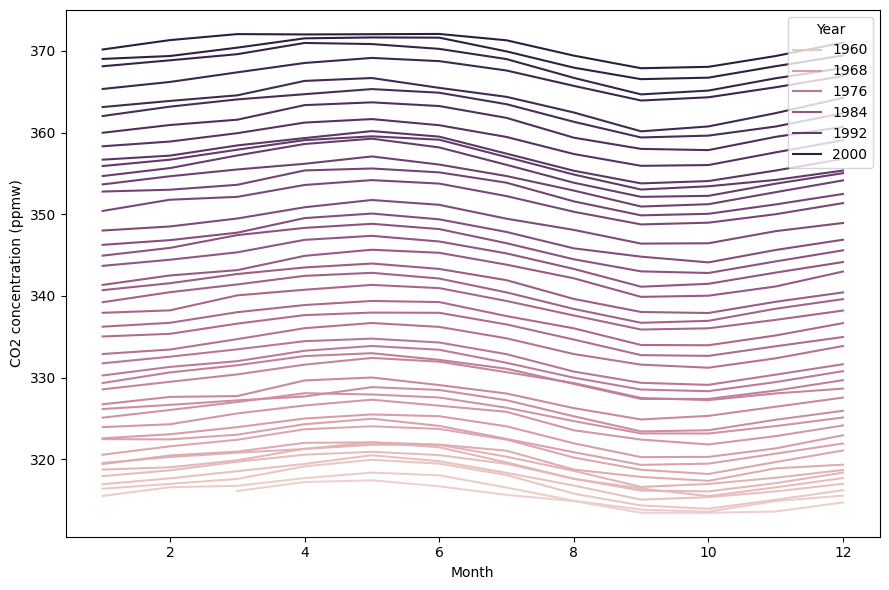

In [ ]:
df['Date'] = df.index
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
month_data = df.groupby(['Year','Month'])['co2'].mean().reset_index()


ax = sns.lineplot(x = "Month", y = "co2", hue = "Year", markers = True, data = month_data)
ax.set_xlabel('Month')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

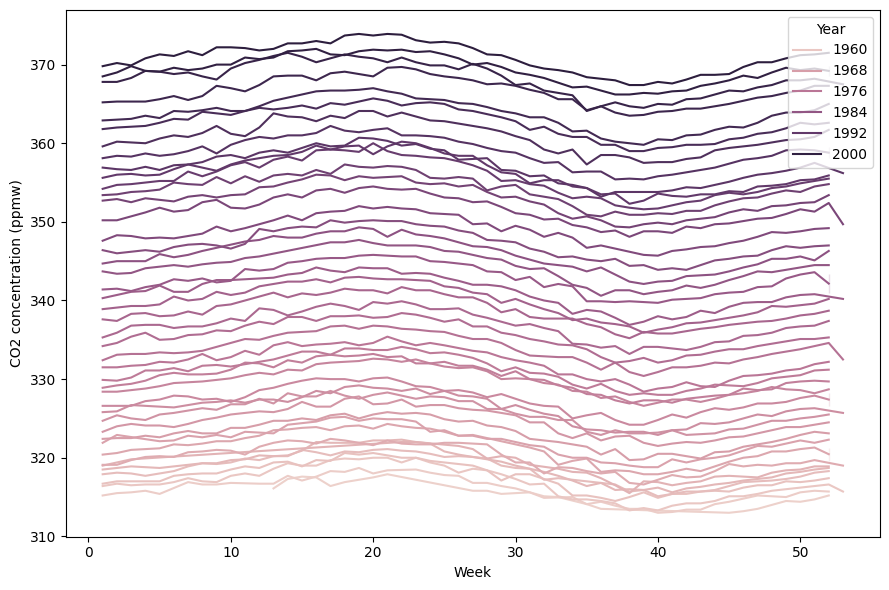

In [ ]:
month_data = df.groupby(['Year','Month','Week'])['co2'].mean().reset_index()


ax = sns.lineplot(x = "Week", y = "co2", hue = "Year", markers = True, data = month_data)
ax.set_xlabel('Week')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

### Outlier check

In [ ]:
dtf_outliers = find_outliers(df['co2'], perc=0.01)

In [ ]:
### outliers index position ###
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"] == 1].index

### exclude outliers ###
ts_clean = remove_outliers(df['co2'], outliers_idx = outliers_index_pos)

In [ ]:
df = pd.concat([df['Date'], ts_clean], axis = 1)

### Test of stationarity

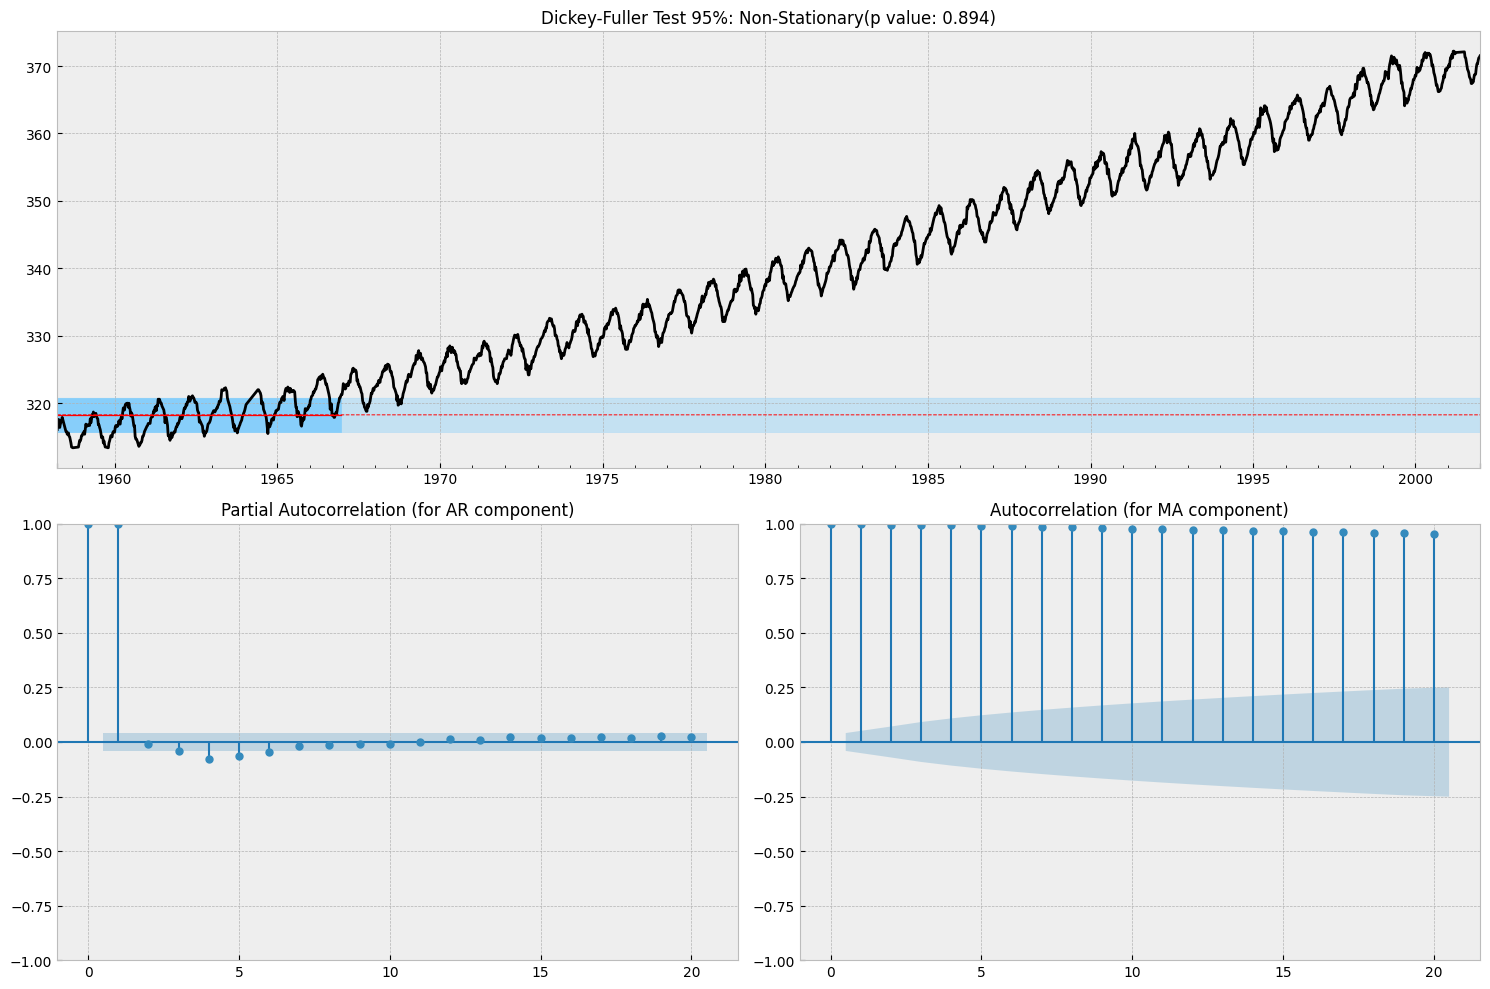

In [ ]:
test_stationarity_acf_pacf(df['co2'], sample = 0.20, maxlag = 20)

In [ ]:
df_diff_seasonal_diff = np.diff(df['co2'], n = 1)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.857614541047363
p-value: 9.291718244413538e-29


In [ ]:
test_stationarity_acf_pacf(pd.Series(df_diff_seasonal_diff), sample = 0.20, maxlag = 20)

In [ ]:
df['unique_id'] = 0
df = df.rename(columns={"Date": "ds", "co2": "y"})
df = df[['unique_id', 'ds', 'y']]

train = df[:-104]
test = df[-104:]

### StatsForecast models

In [ ]:
season_length = 52
horizon = len(test)

sf = StatsForecast(
    df = train,
    models = [OptimizedTheta(season_length = season_length,
                             decomposition_type = "multipicative"),
              SeasonalNaive(season_length = season_length),
              HoltWinters(season_length = season_length, error_type = 'M')],
    freq = 'W',
    n_jobs = -1
)

In [ ]:
crossvalidation_df = sf.cross_validation(df = train,
                                         h = horizon,
                                         step_size = 4,
                                         n_windows = 3)

In [ ]:
print(min(crossvalidation_df.ds), max(crossvalidation_df.ds))

diag_res('OptimizedTheta', 'Optimized Theta')
diag_res('SeasonalNaive', 'Seasonal Naive')
diag_res('HoltWinters', 'Holt Winters')

1997-11-09 00:00:00 1999-12-26 00:00:00
The Smape loss value for Optimized Theta using cross-validation is 0.005778
The RMSE loss value for Optimized Theta using cross-validation is 2.581772
The Smape loss value for Auto ETS using cross-validation is 0.012969
The RMSE loss value for Auto ETS using cross-validation is 8.279461
The Smape loss value for Seasonal Naive using cross-validation is 0.010030
The RMSE loss value for Seasonal Naive using cross-validation is 3.825172
The Smape loss value for Holt Winters using cross-validation is 0.004373
The RMSE loss value for Holt Winters using cross-validation is 1.827801


<ipython-input-79-4f94102146b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['unique_id'] = test['unique_id'].astype(int)


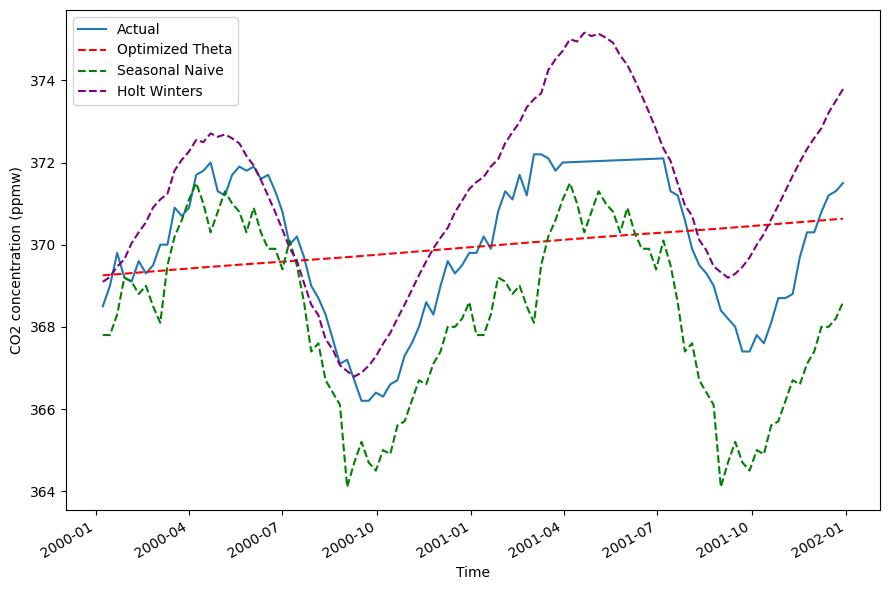

In [ ]:
Y_hat = sf.forecast(horizon, fitted = True)
test['unique_id'] = test['unique_id'].astype(int)
Y_hat.ds = pd.to_datetime(Y_hat.ds)
Y_hat.ds = Y_hat.ds + datetime.timedelta(days=6)
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(Y_hat1['ds'], Y_hat1['y'], label='Actual')
ax.plot(Y_hat1['ds'], Y_hat1['OptimizedTheta'], label = 'Optimized Theta', ls = '--', color = 'red')
ax.plot(Y_hat1['ds'], Y_hat1['SeasonalNaive'], label = 'Seasonal Naive', ls = '--', color = 'green')
ax.plot(Y_hat1['ds'], Y_hat1['HoltWinters'], label = 'Holt Winters', ls = '--', color = 'purple')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

### PatchTST

In [ ]:
val_size = 104
test_size = 104

horizon = 104

nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([10]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
}

models = [NHITS(h = horizon,
                input_size = 2*horizon,
                max_steps = 50),
          AutoNHITS(h = horizon,
                    config = nhits_config,
                    num_samples = 5,
                    input_size = 2*horizon,
                    max_steps = 50),
          NBEATS(h = horizon,
                 input_size = 2*horizon,
                 max_steps = 50),
          PatchTST(h = horizon,
                   input_size = 2*horizon,
                   max_steps = 50),
          TimesNet(h = horizon,
                   input_size = 2*horizon,
                   max_steps = 50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(models = models, freq = 'W')

In [ ]:
preds_df = nf.cross_validation(df = df, val_size = val_size, test_size = test_size, n_windows = None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
nf.models[0].results.get_best_result().config

In [ ]:
preds_df.ds = pd.to_datetime(preds_df.ds)
try:
  preds_df.drop(['y'], axis = 1, inplace = True)
except:
  preds_df = preds_df
preds_df.ds = preds_df.ds + datetime.timedelta(days = 6)
preds_df = pd.merge(preds_df, test, how='left', on=['unique_id', 'ds'])


In [ ]:
preds_df = pd.merge(preds_df, test, how='left', on=['unique_id', 'ds'])

In [ ]:
print(min(test.ds), max(test.ds), min(preds_df.ds), max(preds_df.ds))

2000-01-08 00:00:00 2001-12-29 00:00:00 2000-01-08 00:00:00 2001-12-29 00:00:00


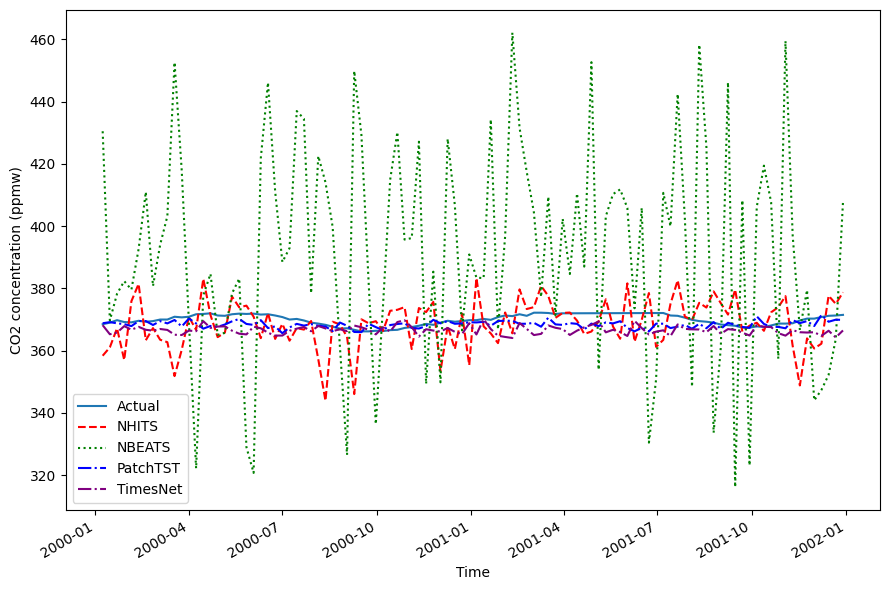

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(preds_df['ds'], preds_df['y'], label='Actual')
ax.plot(preds_df['ds'], preds_df['NHITS'], label='NHITS', ls='--', color='red')
ax.plot(preds_df['ds'], preds_df['NBEATS'], label='NBEATS', ls=':', color='green')
ax.plot(preds_df['ds'], preds_df['PatchTST'], label='PatchTST', ls='-.', color='blue')
ax.plot(preds_df['ds'], preds_df['TimesNet'], label='TimesNet', ls='-.', color='purple')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

### Prophet

In [ ]:
test.drop(['unique_id'], axis = 1, inplace = True)
train.drop(['unique_id'], axis = 1, inplace = True)

add_datepart(train, 'ds', drop = False)
train_ph = train_dset(train,'ds')
train_ph.drop(['Is_year_end', 'Is_year_start'], axis = 1, inplace = True)

add_datepart(test, 'ds', drop = False)
test_ph = train_dset(test,'ds')

#print(list(train_ph.columns))
#print(list(test_ph.columns))

test_ph.head()

ds    y  Year  Month  Week  Day  Dayofyear  Is_month_end  \
0 2000-01-08  368  2000      1     1    8          8             0   
1 2000-01-15  369  2000      1     2   15         15             0   
2 2000-01-22  369  2000      1     3   22         22             0   
3 2000-01-29  369  2000      1     4   29         29             0   
4 2000-02-05  369  2000      2     5    5         36             0   

   Is_month_start  Is_quarter_end  Is_quarter_start  
0               0               0                 0  
1               0               0                 0  
2               0               0                 0  
3               0               0                 0  
4               0               0                 0

In [ ]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
holidays = pd.DataFrame({
  'holiday':'federal',
  'ds': pd.to_datetime(['2018-07-04']),
  'lower_window': -2,
  'upper_window': 2,
})

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2180 104
['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat', 'y', 'residuals']
The Smape loss value for Prophet and Baseline model model is 0.001246
The RMSE loss value for Prophet and Baseline model model is 0.577072


<Figure size 1900x1500 with 0 Axes>

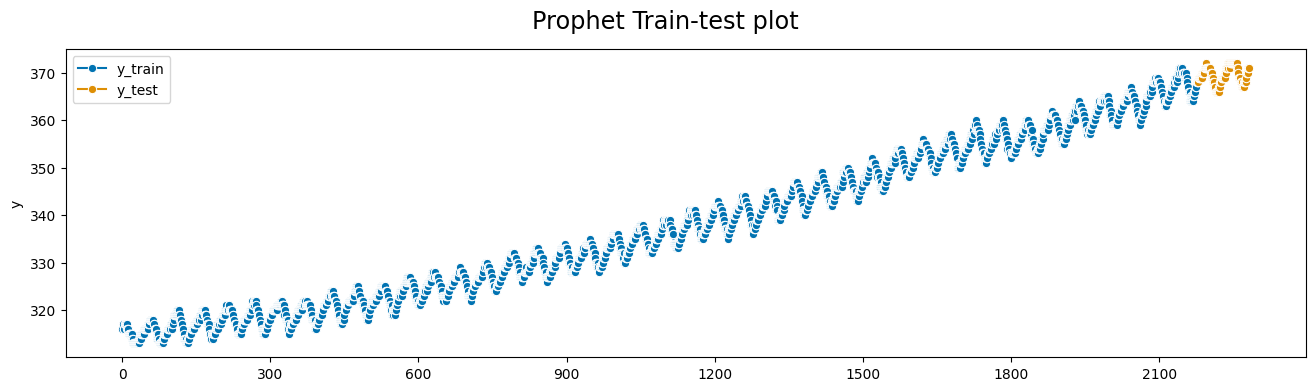

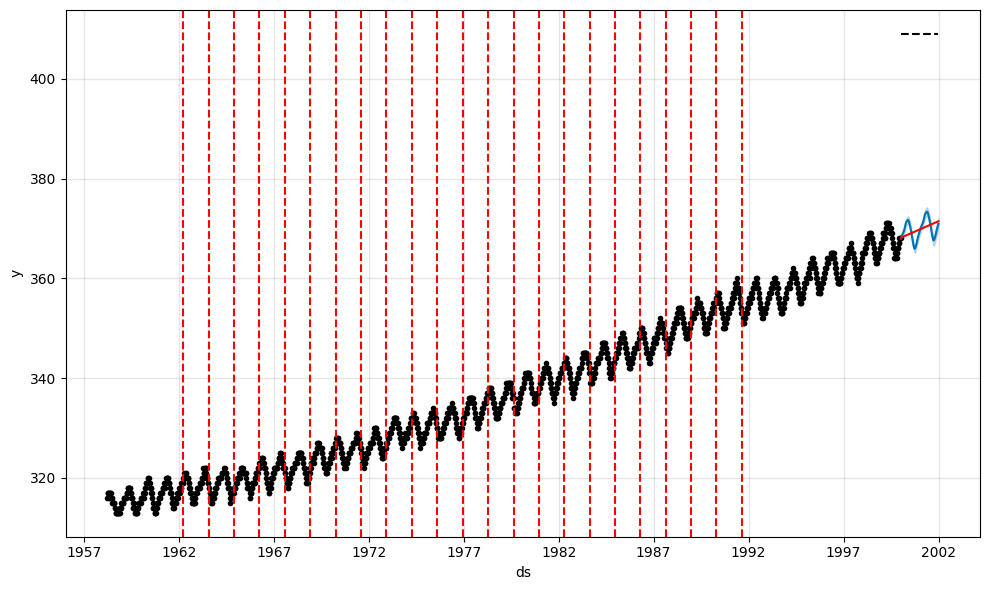

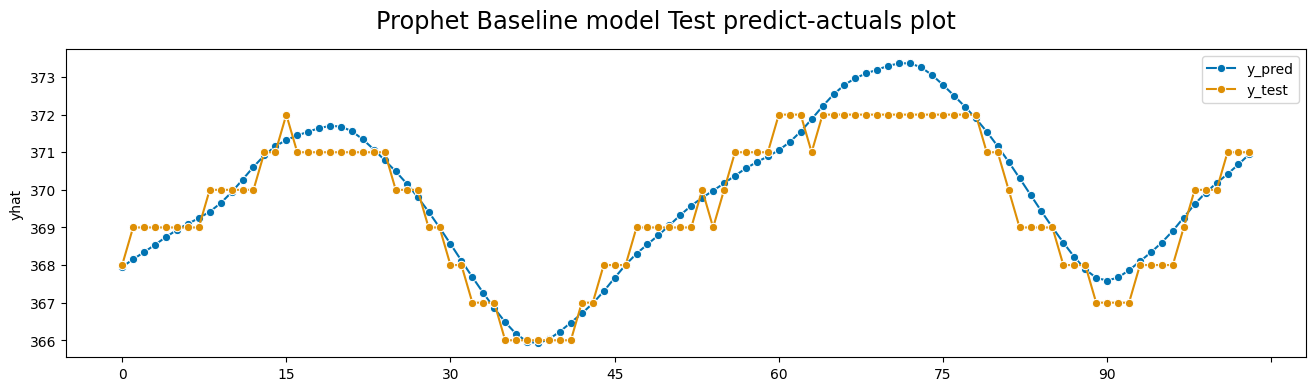

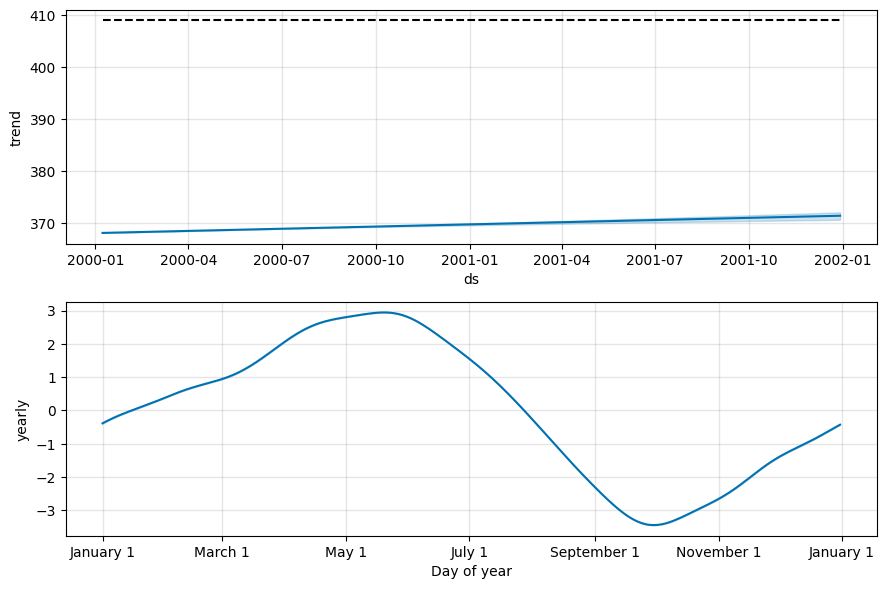

(104, 20)
['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'Day', 'Day_lower', 'Day_upper', 'Dayofyear', 'Dayofyear_lower', 'Dayofyear_upper', 'Is_month_end', 'Is_month_end_lower', 'Is_month_end_upper', 'Is_month_start', 'Is_month_start_lower', 'Is_month_start_upper', 'Is_quarter_end', 'Is_quarter_end_lower', 'Is_quarter_end_upper', 'Is_quarter_start', 'Is_quarter_start_lower', 'Is_quarter_start_upper', 'Month', 'Month_lower', 'Month_upper', 'Week', 'Week_lower', 'Week_upper', 'Year', 'Year_lower', 'Year_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive', 'extra_regressors_additive_lower', 'extra_regressors_additive_upper', 'federal', 'federal_lower', 'federal_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative

<Figure size 1900x1500 with 0 Axes>

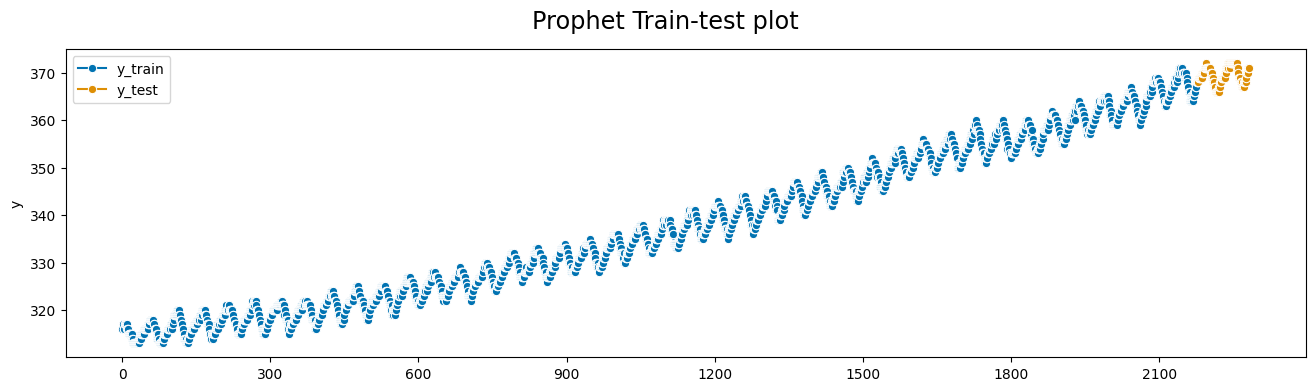

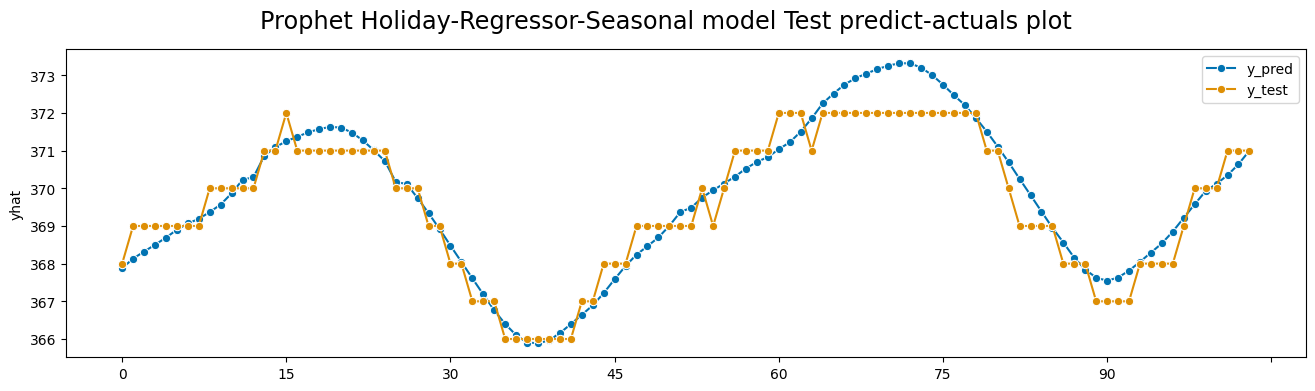

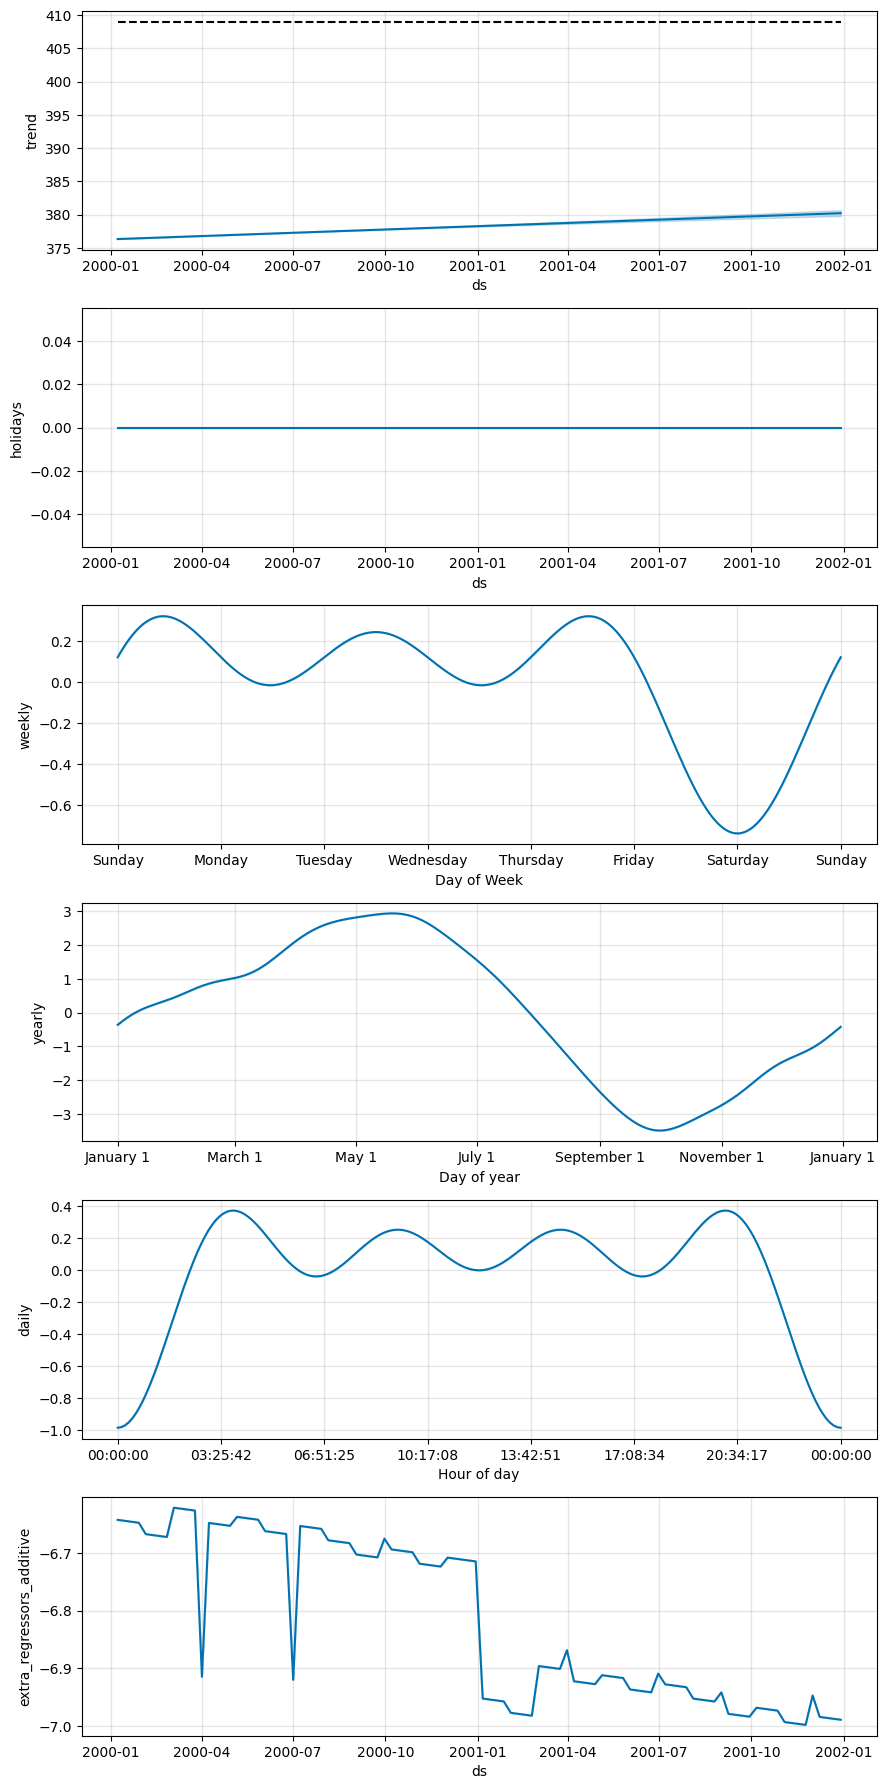

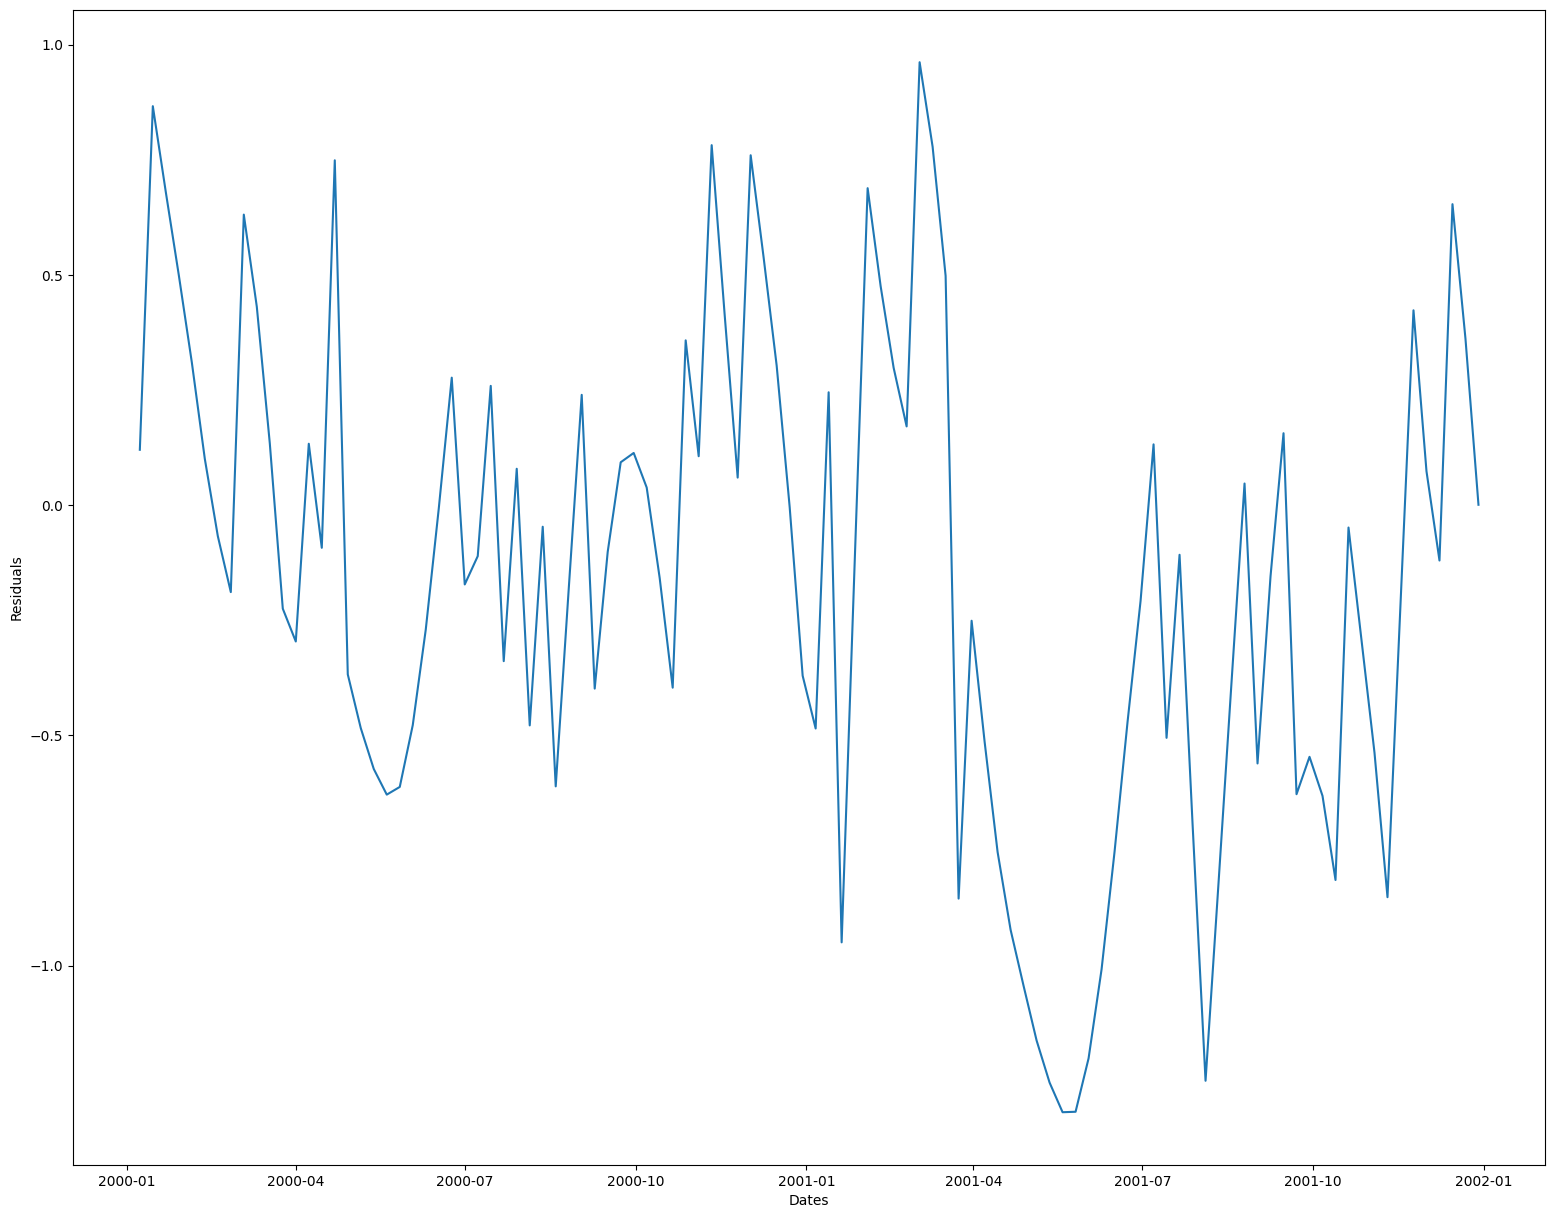

(208, 62)
['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'Day', 'Day_lower', 'Day_upper', 'Dayofyear', 'Dayofyear_lower', 'Dayofyear_upper', 'Is_month_end', 'Is_month_end_lower', 'Is_month_end_upper', 'Is_month_start', 'Is_month_start_lower', 'Is_month_start_upper', 'Is_quarter_end', 'Is_quarter_end_lower', 'Is_quarter_end_upper', 'Is_quarter_start', 'Is_quarter_start_lower', 'Is_quarter_start_upper', 'Month', 'Month_lower', 'Month_upper', 'Week', 'Week_lower', 'Week_upper', 'Year', 'Year_lower', 'Year_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive', 'extra_regressors_additive_lower', 'extra_regressors_additive_upper', 'federal', 'federal_lower', 'federal_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat', 'y', 'residuals']
T

<Figure size 1900x1500 with 0 Axes>

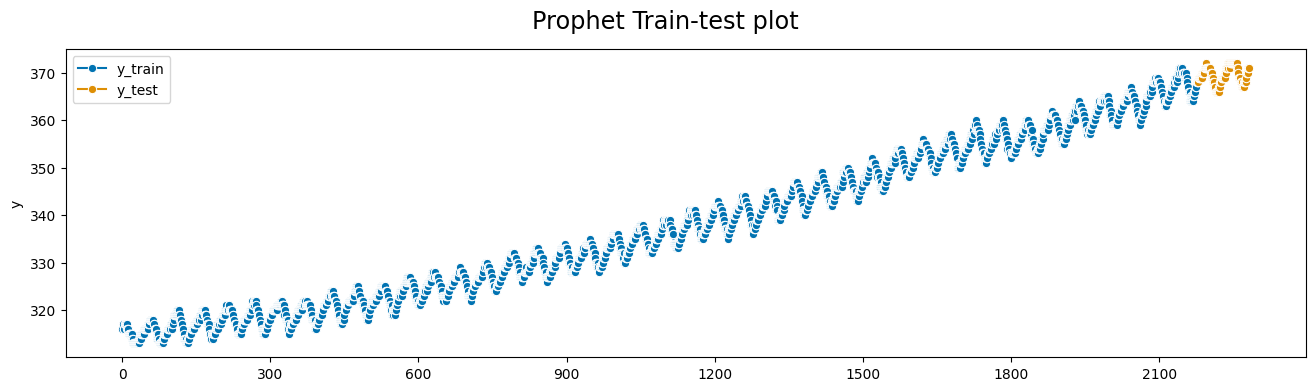

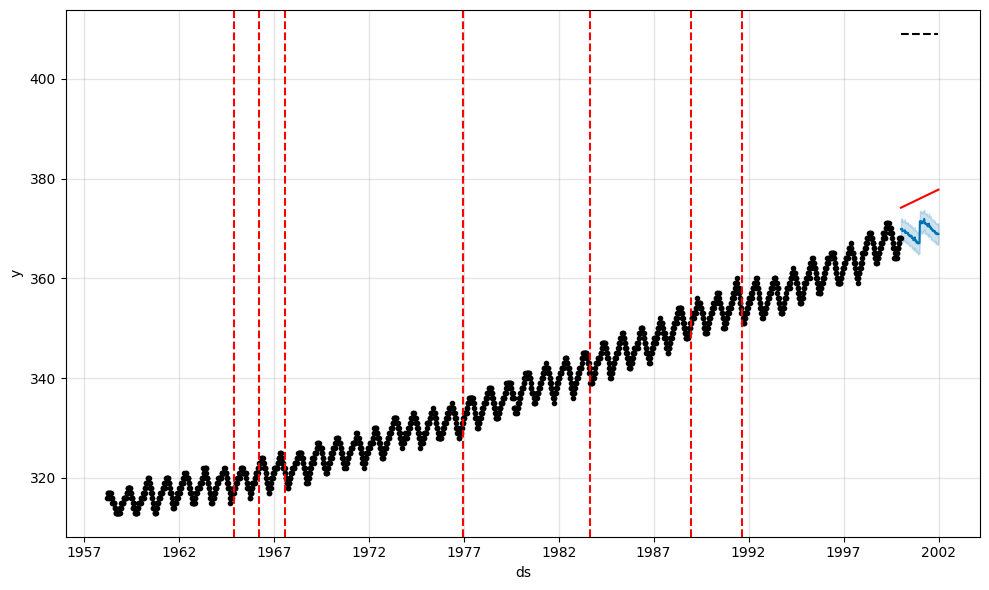

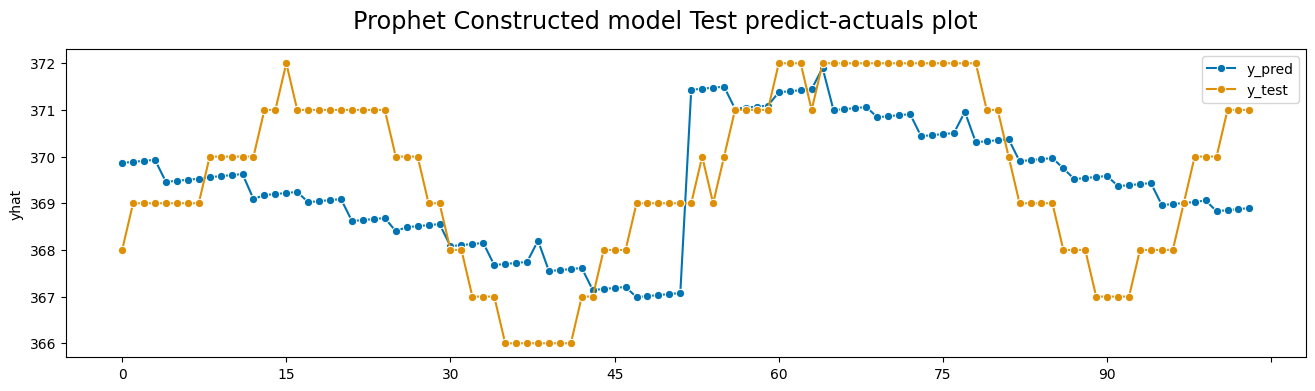

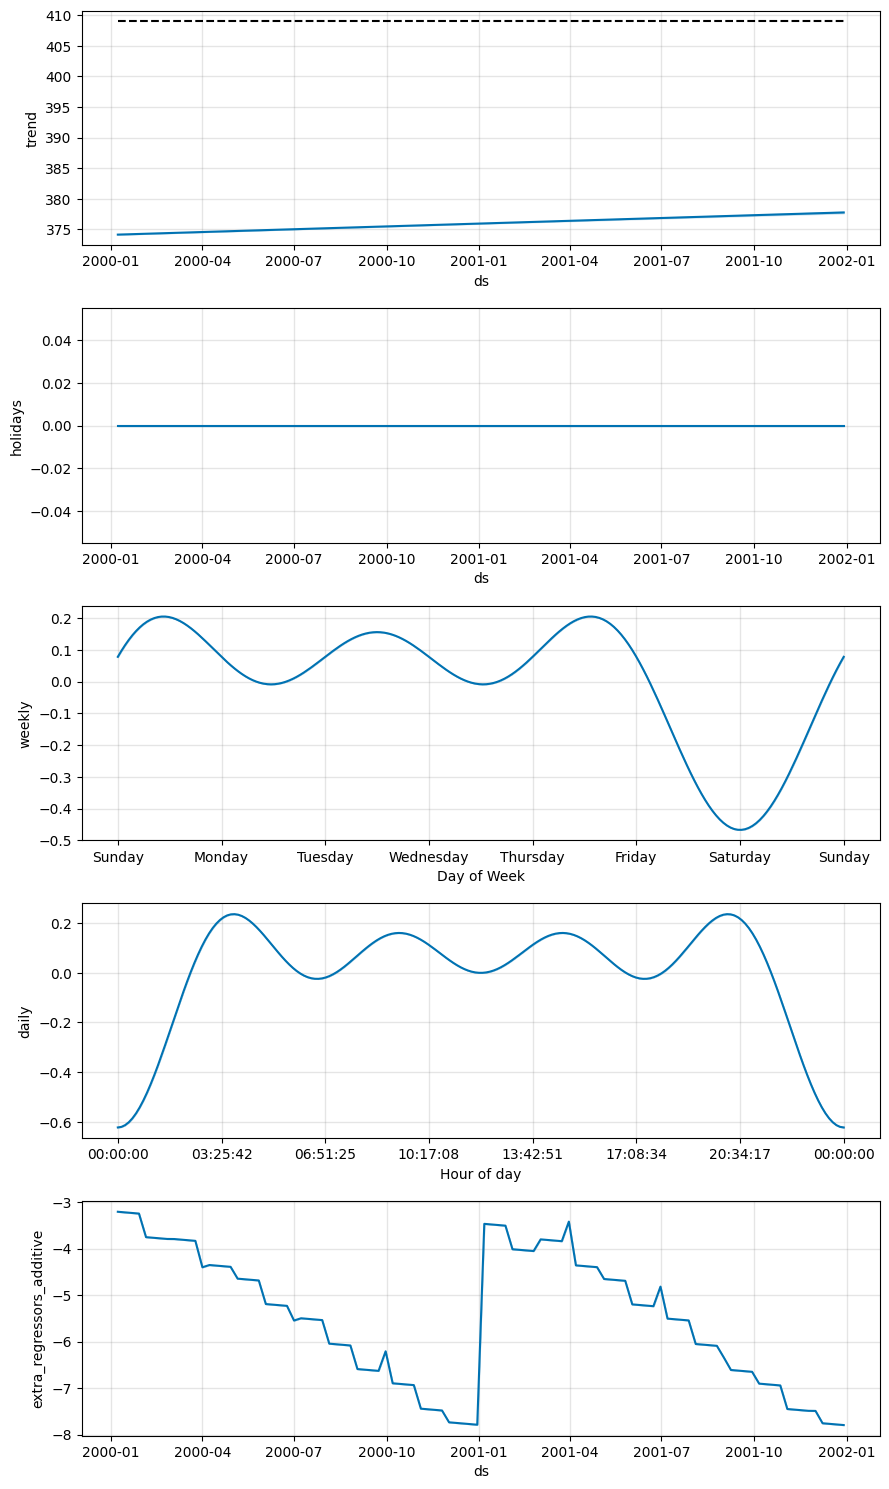

(312, 62)


In [ ]:
cha_res = cap_floor(train_ph, test_ph, 'Prophet')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

for param in params:
    m = Prophet(**param)
    m.fit(train_ph)

    df_cv = cross_validation(model = m, horizon = '104 W')
    df_p = performance_metrics(df_cv, rolling_window = 1)
    mses.append(df_p['mse'].values[0])

tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 34 forecasts with cutoffs between 1965-02-13 00:00:00 and 1998-01-03 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
best_params = params[np.argmin(mses)]

print(best_params)
#best_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01}

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01}


In [ ]:
auto_res = all_mod(train_ph, test_ph, best_params, cha_res)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The Smape loss value for is 0.001306
The RMSE value is 0.5991750634455388


### SARIMA

#### Tests for stationarity

In [ ]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.04671898547111486
p-value: 0.9622293524876886


In [ ]:
df_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.857614541047363
p-value: 9.291718244413538e-29


In [ ]:
min_p = 1
max_p = 3
min_q = 1
max_q = 3

min_P = 1
max_P = 1
min_Q = 1
max_Q = 1

d = 1
D = 0
s = 52

result_df = SARIMA_gridsearch(train['y'], min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 9 unique models


  0%|          | 0/9 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0  (2, 3, 1, 1)  2076.856123
1  (3, 3, 1, 1)  2078.499478
2  (3, 2, 1, 1)  2079.504671
3  (3, 1, 1, 1)  2084.586453
4  (1, 3, 1, 1)  2091.449130

In [ ]:
SARIMA_model = SARIMAX(np.asarray(train['y']), order=(2,1,3), seasonal_order = (1,0,1,52), simple_differencing = False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2180
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 52)   Log Likelihood               -1030.428
Date:                              Tue, 21 Nov 2023   AIC                           2076.856
Time:                                      13:34:33   BIC                           2122.349
Sample:                                           0   HQIC                          2093.488
                                             - 2180                                         
Covariance Type:                       Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4325        nan        nan        nan         nan         nan
ar.L2          0.46

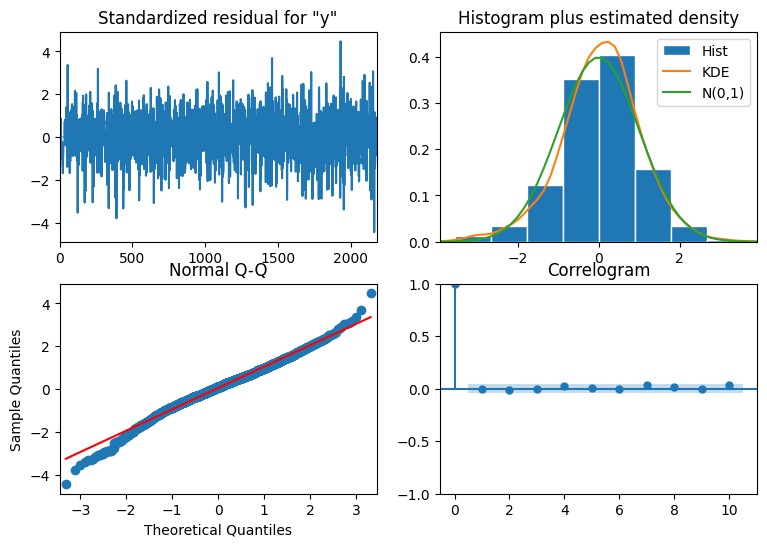

In [ ]:
SARIMA_model_fit.plot_diagnostics();

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


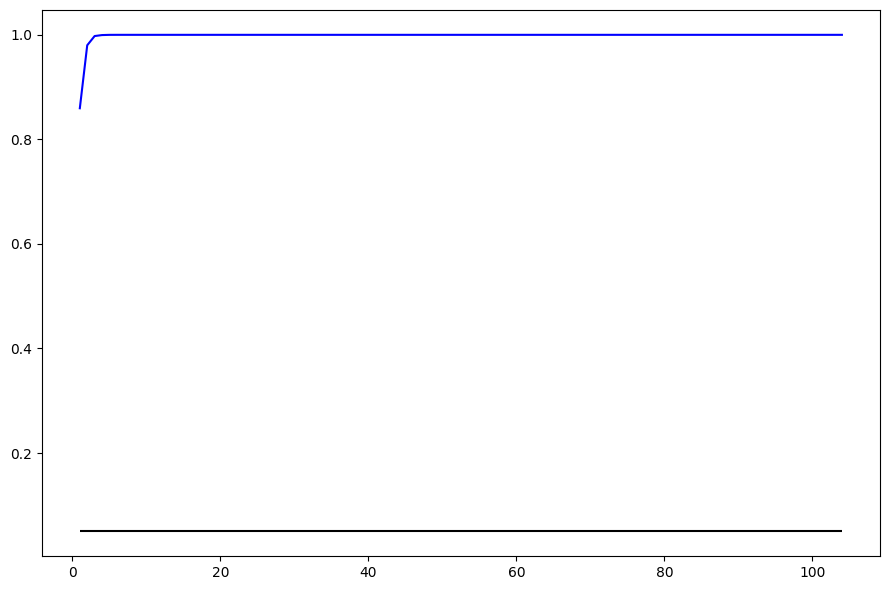

In [ ]:
residuals = SARIMA_model_fit.resid

ljung_box_test(residuals, True, 52)

In [ ]:
predictions = SARIMA_model_fit.get_prediction(1, len(test))
sarima_pred = test[['ds','y']].reset_index()
sarima_pred['yhat'] = pd.Series(predictions.predicted_mean)
sarima_pred['yhat'] = sarima_pred['yhat'] + 52
print(sarima_pred.shape)
sarima_pred.head()

(104, 4)


index         ds      y        yhat
0 2000-01-08 2000-01-08  368.5  368.099946
1 2000-01-15 2000-01-15  369.0  368.944371
2 2000-01-22 2000-01-22  369.8  369.150148
3 2000-01-29 2000-01-29  369.2  369.343909
4 2000-02-05 2000-02-05  369.1  368.716125

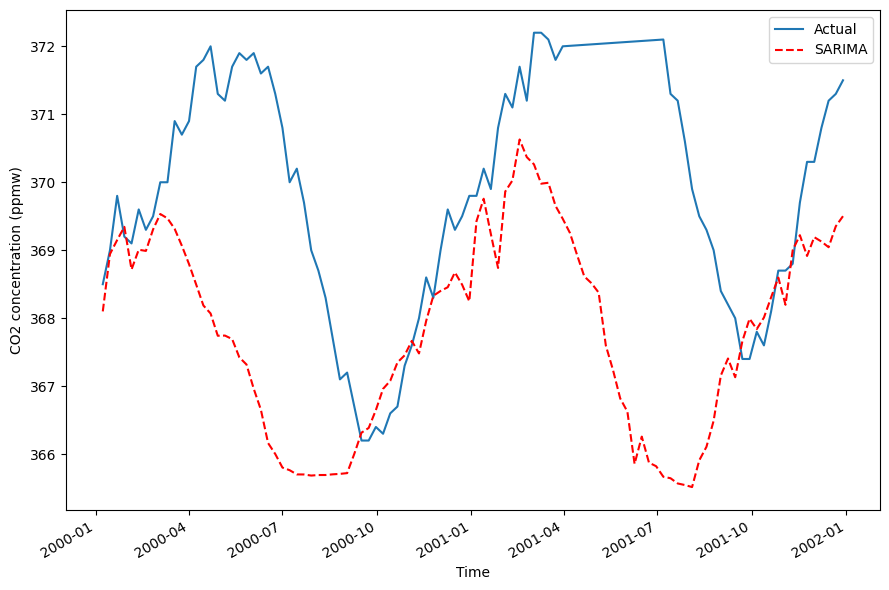

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(sarima_pred['ds'], sarima_pred['y'], label = 'Actual')
ax.plot(sarima_pred['ds'], sarima_pred['yhat'], label = 'SARIMA', ls = '--', color = 'red')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation

In [ ]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), rmse(preds_df['NHITS'], preds_df['y'])],
        'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), rmse(preds_df['NBEATS'], preds_df['y'])],
        'PatchTST': [mae(preds_df['PatchTST'], preds_df['y']), rmse(preds_df['PatchTST'], preds_df['y'])],
        'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), rmse(preds_df['TimesNet'], preds_df['y'])],
        'Baseline Prophet': [mae(cha_res.loc[cha_res.Model == 'Baseline', 'yhat'], cha_res.loc[cha_res.Model == 'Baseline', 'y']),
                             rmse(cha_res.loc[cha_res.Model == 'Baseline', 'yhat'], cha_res.loc[cha_res.Model == 'Baseline', 'y'])],
        'Constructed Prophet': [mae(cha_res.loc[cha_res.Model == 'Constructed', 'yhat'], cha_res.loc[cha_res.Model == 'Constructed', 'y']),
                                rmse(cha_res.loc[cha_res.Model == 'Constructed', 'yhat'], cha_res.loc[cha_res.Model == 'Constructed', 'y'])],
        'HRS Prophet': [mae(cha_res.loc[cha_res.Model == 'HRS', 'yhat'], cha_res.loc[cha_res.Model == 'HRS', 'y']),
                        rmse(cha_res.loc[cha_res.Model == 'HRS', 'yhat'], cha_res.loc[cha_res.Model == 'HRS', 'y'])],
        'Hyperparameter Prophet': [mae(auto_res.loc[auto_res.Model == 'Hyperparameter', 'yhat'], auto_res.loc[auto_res.Model == 'Hyperparameter', 'y']),
                                   rmse(auto_res.loc[auto_res.Model == 'Hyperparameter', 'yhat'], auto_res.loc[auto_res.Model == 'Hyperparameter', 'y'])],
        'Optimized Theta': [mae(Y_hat1['OptimizedTheta'], Y_hat1['y']), rmse(Y_hat1['OptimizedTheta'], Y_hat1['y'])],
        'Seasonal Naive': [mae(Y_hat1['SeasonalNaive'], Y_hat1['y']), rmse(Y_hat1['SeasonalNaive'], Y_hat1['y'])],
        'Holt Winters': [mae(Y_hat1['HoltWinters'], Y_hat1['y']), rmse(Y_hat1['HoltWinters'], Y_hat1['y'])],
        'SARIMA': [mae(sarima_pred['yhat'], sarima_pred['y']), rmse(sarima_pred['yhat'], sarima_pred['y'])]
        }

metrics_df = pd.DataFrame(data = data)
metrics_df.index = ['mae', 'rmse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

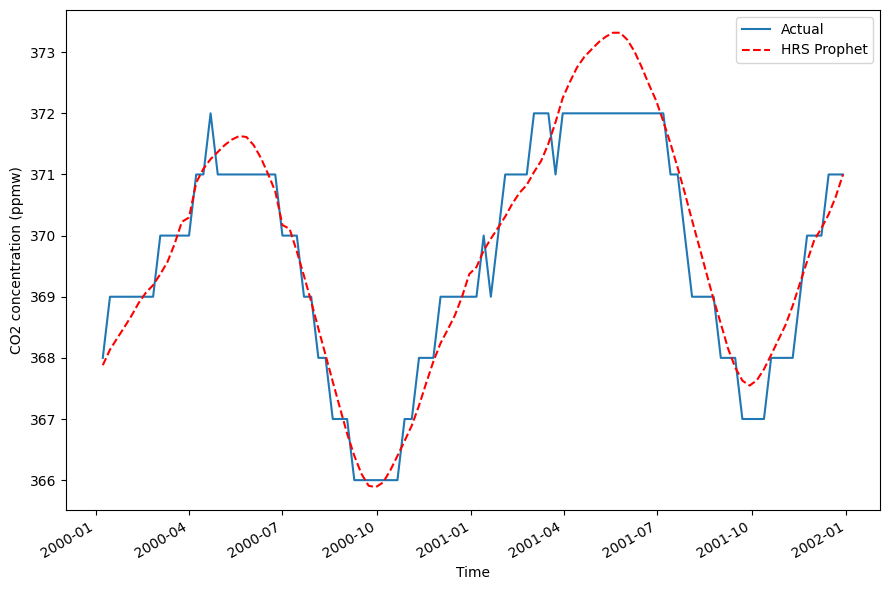

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(cha_res.loc[cha_res.Model == 'HRS', 'ds'], cha_res.loc[cha_res.Model == 'HRS', 'y'], label = 'Actual')
ax.plot(cha_res.loc[cha_res.Model == 'HRS', 'ds'], cha_res.loc[cha_res.Model == 'HRS', 'yhat'], label = 'HRS Prophet', ls = '--', color = 'red')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()